In [1]:
using Graphs

g = KarateGraph()
A = adjacency_matrix(KarateGraph())

using DrWatson
quickactivate(@__DIR__)

using PolarizationFramework

In [2]:
triads = get_triads(A)
links = get_links_in_triads(triads)
A2 = get_adj_necessary_links(size(A)[1], links; typ = Float64);

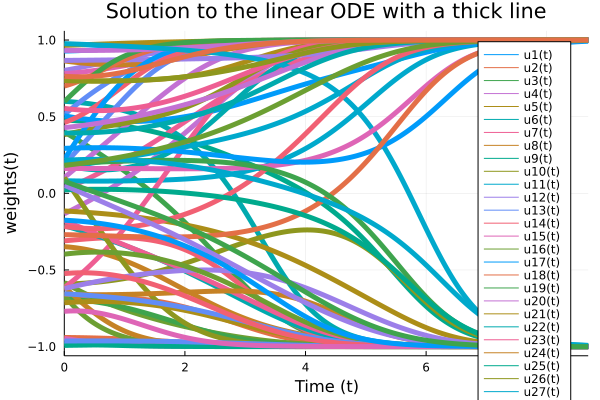

In [3]:
n = size(A2)[1]
attr = BinaryAttributes(3)

gamma = 0.0001
maxtime = 10000.
ode_fun = PolarizationFramework.Heider9!
# ode_fun = Heider72!
solver = PolarizationFramework.AutoTsit5(PolarizationFramework.Rodas5(autodiff = false))
show_plot = true

(ishb_sim_par, solend, solu, u0, xy_attr, sol) = 
    calc_heider_attr(n, attr, gamma, maxtime, ode_fun, solver, show_plot;
    all_links_mat = A2);

In [5]:
ishb_sim_par

10-element Vector{Any}:
  true
 false
    -0.18181818181818182
     0.9993853415693412
 false
 false
      [11.0, 0.0, 34.0, 0.0]
  true
     0.7555555555555555
  true

In [4]:
using BenchmarkTools
using LinearAlgebra

using DifferentialEquations

In [73]:
x = sol[1].*A2
xs = sign.(Symmetric(x))

dx = similar(x)
lay1mul = zeros(n, n)
x_sim = zeros(n, n)

mask = triu(trues(size(u0)), 1)
mask .*= A2

triads_around_links_dict = PolarizationFramework.get_triangles_around_links(triads)
counts = PolarizationFramework.link_triangles_count(triads_around_links_dict; links = links)
triads_count_mat = PolarizationFramework.link_triangles_mat(n, links, counts)
triads_count_mat_inv = PolarizationFramework.link_triangles_mat_inv(n, links, counts)

p1 = (n, gamma .* xy_attr, lay1mul, x_sim, mask, triads_count_mat_inv)
p2 = (n, gamma .* xy_attr .* triads_count_mat, lay1mul, x_sim, mask)

(34, [0.0 -0.0016333333333333332 … -0.0 -0.0; 0.0 0.0 … 0.0 -0.0; … ; 0.0 0.0 … 0.0 -0.003333333333333333; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0])

In [83]:
condition_here(u, t, integrator) = condition2(u, t, integrator, mask)
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition_here, affect!)

#ode and model parameters
tspan = (0.0, maxtime)

prob72 = ODEProblem(Heider72!, sol[1], tspan, p1)
sol = solve(
        prob72,
        solver,
        reltol = 1e-6,
        abstol = 1e-12,
        callback = cb,
        isoutofdomain = (u, p, t) -> any(x -> abs.(x) >= 1, u),
        save_everystep = false,
    )

retcode: Terminated
Interpolation: 1st order linear
t: 3-element Vector{Float64}:
  0.0
 13.171497585644909
 13.171497585644909
u: 3-element Vector{Matrix{Float64}}:
 [0.0 -0.17900890962397709 … 0.0 -0.0; 0.0 0.0 … -0.0 0.0; … ; 0.0 0.0 … 0.0 -0.45153149741723064; 0.0 0.0 … 0.0 0.0]
 [0.0 0.9999981064353699 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 -0.9999999997773603; 0.0 0.0 … 0.0 0.0]
 [0.0 0.9999981064353699 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 -0.9999999997773603; 0.0 0.0 … 0.0 0.0]

In [6]:
u0_inc = sol[1];
link_indices = findall(triu(A2,1)[:] .> 0)
u0 = zeros(n,n)
u0[link_indices] = sol[1]
u0;

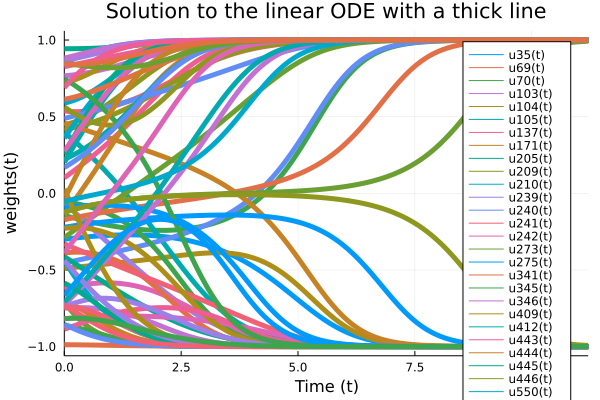

[0.0 -0.9999949678676521 -0.9999999996147618 0.9999999925846024 0.9999999893306242 0.9999999950994605 0.9999999996109156 -0.999999886386923 -0.9999999999181743 0.0 -0.9999999871601102 0.0 0.999999999510564 0.999999990572386 0.0 0.0 0.0 0.9999996068367942 0.0 -0.9999995918639978 0.0 -0.9998656206459033 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.9999892153996826 -0.9999945895829301 0.0 0.0 0.0 0.9999904657161893 0.0 0.0 0.0 0.0 0.0 -0.9999924797504592 0.0 0.0 0.0 -0.9999995383749491 0.0 0.9999988657265044 0.0 0.9998630507096626 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 -0.9999998311554147 0.0 0.0 0.0 0.9999998624708075 0.9999999998818421 0.0 0.0 0.0 0.0 -0.9999999349461196 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.9999999991255805 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.9999998417196997 0.0 0.0 0.0 0.0 0.9999999990249395 0.9999999040564153 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0

In [13]:
(ishb_sim_par, solend, solu, u0, xy_attr, sol72) = 
    calc_heider_attr(n, attr, gamma, maxtime, Heider72!, solver, show_plot, u0, xy_attr;
    all_links_mat = A2);

In [14]:
ishb_sim_par

10-element Vector{Any}:
  true
 false
    -0.6285714285714286
     0.9998288310591726
 false
 false
      [8.0, 0.0, 37.0, 0.0]
  true
     0.8222222222222222
  true

In [20]:
maximum(abs.(sol72[end][link_indices] - sol[end]))

0.001802773160218707

In [8]:
reps = 10
difs = zeros(reps)

for i = 1:reps
    u0 = triu((rand(n, n) * 2) .- 1, 1)
    val0_attr = get_attributes(attr, n)
    xy_attr = get_attribute_layer_weights(attr, val0_attr)

    (ishb_sim_par72, solend, solu72, u0, xy_attr, sol72) = 
        calc_heider_attr(n, attr, gamma, maxtime, Heider72!, solver, false, u0, xy_attr;
        all_links_mat = A2);

    # u0 = u0[link_indices]

    (ishb_sim_par9, solend, solu9, u0, xy_attr, sol) = 
        calc_heider_attr(n, attr, gamma, maxtime, Heider9!, solver, false, u0, xy_attr;
        all_links_mat = A2);
    println(ishb_sim_par72[7] == ishb_sim_par9[7])
    difs[i] = maximum(abs.(solu72[link_indices] .- solu9))
    # println()

    # println(ishb_sim_par9 == ishb_sim_par72)
end
difs

true
true
true


true
true
true
true
true
true
true


10-element Vector{Float64}:
 1.9424691688474383e-7
 0.002133412731452844
 0.0005321483748627065
 2.455678551727125e-6
 0.0015831550386307125
 0.0025279890646138226
 0.0004552006050640989
 0.0010231706177650235
 0.0016908169130613881
 0.0020275698399363495

In [16]:
all_triads = get_triads(A2);

#Heider72!
all_links = get_links_in_triads(all_triads)
triads_around_links_dict = get_triangles_around_links(all_triads)
counts = link_triangles_count(triads_around_links_dict; links = all_links)
triads_count_mat = PolarizationFramework.link_triangles_mat_inv(n, all_links, counts)

# Heider9!
link_indices = findall(triu(A2,1)[:] .> 0) 
nl = length(link_indices)

link_pairs = get_triangles_around_links(triads_around_links_dict, all_links)
link_pairs_triad_cnt = [length(link) for link in link_pairs];

In [20]:
u0 = triu((rand(n, n) * 2) .- 1, 1)
val0_attr = get_attributes(attr, n)
xy_attr = get_attribute_layer_weights(attr, val0_attr)

@benchmark calc_heider_attr(n, attr, gamma, maxtime, Heider72!, solver, false, u0, xy_attr; all_links_mat = A2, all_triads = all_triads, triads_count_mat = triads_count_mat, link_indices = link_indices, link_pairs = link_pairs, link_pairs_triad_cnt = link_pairs_triad_cnt)


BenchmarkTools.Trial: 1356 samples with 1 evaluation.
 Range (min … max):  2.871 ms …   7.106 ms  ┊ GC (min … max): 0.00% … 33.59%
 Time  (median):     3.355 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.682 ms ± 860.444 μs  ┊ GC (mean ± σ):  8.98% ± 14.27%

    ▁▃▆██▇▄▄▂▂▁                                                
  ▃▅███████████▇▆▅▆▄▃▃▃▂▃▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▂▂▃▃▄▃▅▄▄▄▃▄▃▄▃▂ ▄
  2.87 ms         Histogram: frequency by time        6.06 ms <

 Memory estimate: 20.98 MiB, allocs estimate: 786.

In [21]:
@benchmark calc_heider_attr(n, attr, gamma, maxtime, Heider9!, solver, false, u0, xy_attr; all_links_mat = A2, all_triads = all_triads, triads_count_mat = triads_count_mat, link_indices = link_indices, link_pairs = link_pairs, link_pairs_triad_cnt = link_pairs_triad_cnt)


BenchmarkTools.Trial: 5475 samples with 1 evaluation.
 Range (min … max):  622.339 μs … 15.555 ms  ┊ GC (min … max):  0.00% … 90.70%
 Time  (median):     719.764 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   908.696 μs ±  1.249 ms  ┊ GC (mean ± σ):  16.03% ± 10.81%

  █▅▄▂                                                         ▁
  ████▇▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆▆ █
  622 μs        Histogram: log(frequency) by time      10.7 ms <

 Memory estimate: 1.71 MiB, allocs estimate: 15977.

In [19]:
u0

34×34 Matrix{Float64}:
 0.0  -0.607217  -0.0438846   0.602142  …   0.0       -0.0        0.0
 0.0   0.0        0.249436    0.443984     -0.0       -0.0        0.0
 0.0   0.0        0.0        -0.969952      0.0        0.966865  -0.0
 0.0   0.0        0.0         0.0           0.0        0.0        0.0
 0.0   0.0        0.0         0.0           0.0       -0.0       -0.0
 0.0   0.0        0.0         0.0       …  -0.0        0.0       -0.0
 0.0   0.0        0.0         0.0          -0.0        0.0       -0.0
 0.0   0.0        0.0         0.0          -0.0       -0.0        0.0
 0.0   0.0        0.0         0.0          -0.0        0.856876   0.252457
 0.0   0.0        0.0         0.0          -0.0       -0.0        0.0
 ⋮                                      ⋱                        
 0.0   0.0        0.0         0.0       …  -0.636411  -0.0        0.0
 0.0   0.0        0.0         0.0          -0.0        0.0        0.939326
 0.0   0.0        0.0         0.0           0.0       -0.0   

In [33]:
triads[25:end]

21-element Vector{Any}:
 (3, 4, 14)
 (3, 9, 33)
 (6, 7, 17)
 (9, 31, 33)
 (9, 31, 34)
 (9, 33, 34)
 (15, 33, 34)
 (16, 33, 34)
 (19, 33, 34)
 (21, 33, 34)
 (23, 33, 34)
 (24, 28, 34)
 (24, 30, 33)
 (24, 30, 34)
 (24, 33, 34)
 (25, 26, 32)
 (27, 30, 34)
 (29, 32, 34)
 (30, 33, 34)
 (31, 33, 34)
 (32, 33, 34)

In [27]:
sum([7 in triad for triad in triads])

3

In [22]:
triangles(g)[[6,7,17,27,30,34,29,32]]

8-element Vector{Int64}:
  3
  3
  1
  1
  4
 15
  1
  3

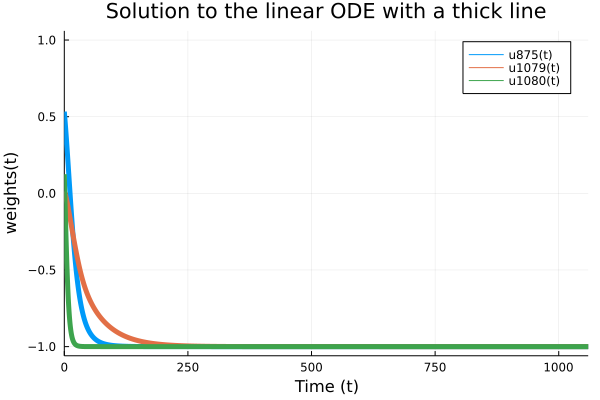

In [110]:
mask2 = zeros(Bool, size(mask))
mask2[25,26] = 1
mask2[25,32] = 1
mask2[26,32] = 1

h = plot(
            sol,
            linewidth = 5,
            title = "Solution to the linear ODE with a thick line",
            xaxis = "Time (t)",
            yaxis = "weights(t)",
            ylim = [-1, +1],
            vars = reshape(1:n^2, n, n)[mask2],
        )

In [98]:
reshape(1:n^2, n, n)[mask2]

LoadError: BoundsError: attempt to access 34×34 reshape(::UnitRange{Int64}, 34, 34) with eltype Int64 at index [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]]

In [10]:
using LinearAlgebra
triangles(Graph(Symmetric(A2)))

34-element Vector{Int64}:
 18
 12
 11
 10
  2
  3
  3
  6
  5
  0
  2
  0
  1
  ⋮
  1
  4
  1
  1
  1
  1
  1
  4
  3
  3
 13
 15